In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import os
os.chdir('/content/drive/MyDrive/ComputerVs/Project_KTHP')

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## PROCESS FUNCTION

In [53]:
def find_image_orientation(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    orientation = cv2.phase(sobel_x, sobel_y, angleInDegrees=False)
    return np.absolute(orientation)

def list_edge_coordinates(image):
    coordinates = []
    x, y = image.shape
    for a in range(x):
        for b in range(y):
            if image[a, b] != 0:
                coordinates.append((a, b))
    return coordinates

def find_reference_point(coordinates):
    x = sum([coord[0] for coord in coordinates]) / len(coordinates)
    y = sum([coord[1] for coord in coordinates]) / len(coordinates)
    return int(x), int(y)

# Create R-table from template
def create_R_table(image, reference_point, coordinates):
    gradient = find_image_orientation(image)
    R_table = {}
    for point in coordinates:
        # compute vector R from edge to reference point
        rx = reference_point[0] - point[0]
        ry = reference_point[1] - point[1]
        r = (rx, ry)
        phi = gradient[point[0], point[1]]

        # Save vector R in r-table based on gradient orientation
        if phi not in R_table:
            R_table[phi] = [r]
        else:
            R_table[phi].append(r)
    return R_table

def find_accumulator_matrix(image_canny, R_table):
    rows, cols = image_canny.shape
    edge_coordinates = list_edge_coordinates(image_canny)
    gradient = find_image_orientation(image_canny)
    accumulator = np.zeros((rows, cols))
    
    for edge in edge_coordinates:
        phi = gradient[edge[0], edge[1]]

        if phi in R_table:
            for vector in R_table[phi]:
                x = edge[0] + vector[0]
                y = edge[1] + vector[1]
                if 0 <= x < rows and 0 <= y < cols:
                    accumulator[x, y] += 1

    return accumulator

def find_local_maxima(accumulator_matrix, threshold):
    maxima_indices = []
    while True:
        max_val = np.max(accumulator_matrix)
        if max_val < threshold:
            break

        max_idx = np.unravel_index(np.argmax(accumulator_matrix), accumulator_matrix.shape)
        maxima_indices.append(max_idx)

        accumulator_matrix[max_idx[0] - 10:max_idx[0] + 10, max_idx[1] - 10:max_idx[1] + 10] = 0

    return maxima_indices



## READ AND PROCESS TEMPLATE

In [48]:
templates = ['template_2_1.png','template_2_2.png']
R_tables = []

for template_path in templates:
    template = cv2.imread(template_path)
    template_grayscale = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    template_canny = cv2.Canny(template_grayscale, 50, 150)
    template_coordinates = list_edge_coordinates(template_canny)
    template_reference = find_reference_point(template_coordinates)
    template_r_table = create_R_table(template_canny, template_reference, template_coordinates)
    R_tables.append(template_r_table)

## READ AND PROCESS ORIGINAL IMAGE

In [49]:

image = cv2.imread('bien_bao_nguy_hiem_2.jpg')
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_canny = cv2.Canny(grayscale, 50, 150)

accumulator_matrices = []

for R_table in R_tables:
    accumulator_matrix = find_accumulator_matrix(image_canny, R_table)
    accumulator_matrices.append(accumulator_matrix)

copy = np.copy(image)
square_size = 50
threshold = 0.5 * np.max(accumulator_matrices[0])

for accumulator_matrix in accumulator_matrices:
    maxima_indices = find_local_maxima(accumulator_matrix, threshold)
    for max_x, max_y in maxima_indices:
        cv2.rectangle(copy, (max_y - square_size, max_x - square_size),
                      (max_y + square_size, max_x + square_size), (255, 0, 0), 3)


## SHOW RESULT

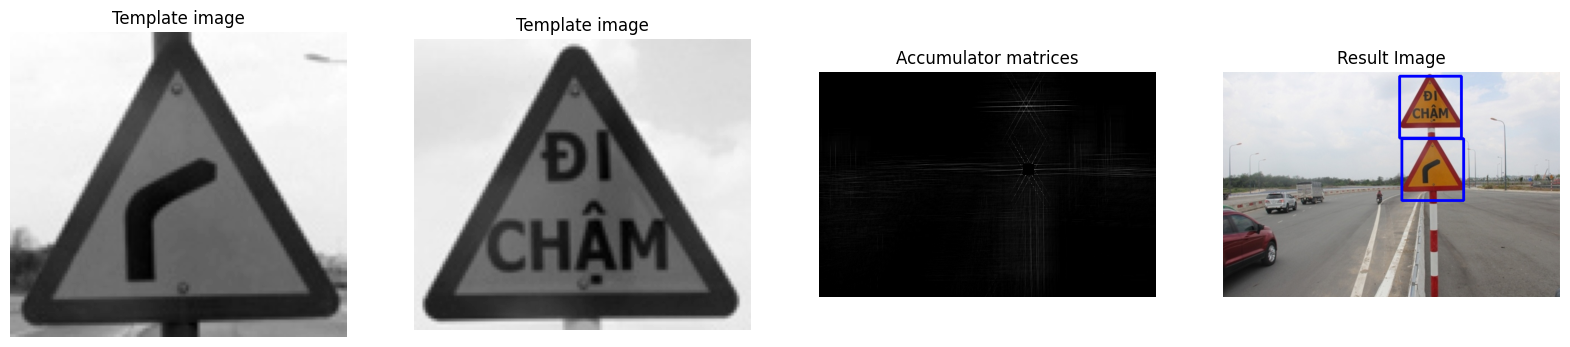

In [47]:
f, axarr = plt.subplots(1, len(templates) + 2, figsize=(20, 10))

for i, template_path in enumerate(templates):
    template = cv2.imread(template_path)
    template_grayscale = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    axarr[i].set_title('Template image')
    axarr[i].imshow(template_grayscale, cmap='gray')
    axarr[i].axis('off')

axarr[len(templates)].set_title('Accumulator matrices')
for i, accumulator_matrix in enumerate(accumulator_matrices):
    axarr[len(templates) + i].imshow(accumulator_matrix, cmap='gray')
    axarr[len(templates) + i].axis('off')

axarr[-1].set_title('Result Image')
axarr[-1].imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
axarr[-1].axis('off')
plt.show()
